In [125]:
import os
import re
import json
import time
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from web3 import Web3
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))

def exec(commandString):
    output_stream = os.popen(commandString)
    res = output_stream.read()
    output_stream.close()
    return res

def extractAddress(response, label):
    match = re.findall(re.escape(label) + r"\s+0x[a-fA-F0-9]{40}", response)
    return match[0].split()[-1]

In [126]:
currentTime = int(time.time() * 1000)
daySeconds = 24*3600
dayMSeconds = 1000*daySeconds
START_DATE = 1561687200000;
END_DATE = currentTime  - dayMSeconds - (currentTime%dayMSeconds)
nDAYS = 'max'
AMPL_INITIAL_SUPPLY = 50000000

amplHistroy = json.loads(requests.get('https://web-api.ampleforth.org/eth/token-rebase-history').content)
amplDf = pd.DataFrame(amplHistroy, columns=['epoch', 'price', 'price_target', 'supply', 'time'])
amplDf['time'] = (amplDf['time'] - (amplDf['time'] % daySeconds))
amplDf['time'] = pd.to_datetime(amplDf['time'], unit='s')
amplDf = amplDf.set_index('time')
amplDf['marketcap'] = amplDf['price'] * amplDf['supply']

# NOTE: starting from july 30 2020 (max supply)
amplDf = amplDf[amplDf.epoch > 396]

In [137]:
TRANCHE_RATIOS = [350, 650]

BOND_DURATION_EPOCHS = 56 # number of rebases before the bond ends
ISSUE_FREQUENCY_EPOCHS = 14 # number of rebases before a new bond is issued

TIME_BETWEEN_REBASES = 86400
BOND_DURATION = BOND_DURATION_EPOCHS * TIME_BETWEEN_REBASES
ISSUE_FREQUENCY = ISSUE_FREQUENCY_EPOCHS * TIME_BETWEEN_REBASES

BOND_YIELDS = [1.0, 0]
YIELD_DECIMALS = 18

AMPL_DECIMALS = 9
PRICE_DECIMALS = 8

def deployContracts():
    addrs = { }
    addrs["ampl"] = extractAddress(exec('yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache deploy:MockAMPL'), "AMPL")
    
    addrs["bondFactory"] = extractAddress(exec('yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache deploy:BondFactory'), "Bond Factory")

    addrs["issuer"] = extractAddress(exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache deploy:BondIssuer \
  --bond-factory-address "%s" \
  --bond-duration "%s" \
  --issue-frequency "%s" \
  --issue-window-offset "0" \
  --collateral-token-address "%s" \
  --tranche-ratios "%s"
    """ % (addrs["bondFactory"], int(BOND_DURATION), int(ISSUE_FREQUENCY), addrs["ampl"], TRANCHE_RATIOS)), "Bond issuer")
    
    addrs["spot"] = extractAddress(exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache deploy:PerpetualTranche \
  --bond-issuer-address "%s" \
  --collateral-token-address "%s" \
  --name "SPOT" \
  --symbol "SPOT"
    """ % (addrs["issuer"], addrs["ampl"])), "perp")
    
    addrs["router"] = extractAddress(exec("yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache deploy:Router"), "router")

    return addrs

def setYield(spot, ampl, index, yieldVal):
    exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache deploy:YieldStrategy:setYield \
  --yield-strategy-address "%s" \
  --collateral-token-address "%s" \
  --tranche-ratios "%s" \
  --tranche-index "%s" \
  --tranche-yield "%s"
    """ % (spot.functions.yieldStrategy().call(), ampl.address, TRANCHE_RATIOS, index, yieldVal))

def trancheAndDeposit(router, spot, collateralAmount, walletIdx=0):
    exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:trancheAndDeposit \
  --router-address "%s" \
  --perp-address "%s" \
  --collateral-amount "%s" \
  --from-idx "%s"
    """ % (router.address, spot.address, collateralAmount, walletIdx))

def redeem(router, spot, amount, walletIdx=0):
        exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:redeem \
  --router-address "%s" \
  --perp-address "%s" \
  --amount "%s" \
  --from-idx "%s"
    """ % (router.address, spot.address, amount, walletIdx))

def redeemTranches(issuer, wallet):
        exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:redeemTranches \
  --bond-issuer-address "%s" \
  --from-idx "%s"
    """ % (issuer.address, wallet))

def trancheAndRolloverMax(router, spot, walletIdx):
    exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:trancheAndRolloverMax \
  --router-address "%s" \
  --perp-address "%s" \
  --from-idx "%s"
    """ % (router.address, spot.address, walletIdx))
    
def advanceClock(timeInSec):
    exec("""yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:increaseTimeBy %s""" % (timeInSec))

def rebase(ampl, perc):
    exec("""yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:rebase:MockAMPL --ampl-address %s --rebase-perc %s""" % (ampl.address, perc))

def printInfo(spot):
    print(exec("""
yarn workspace @ampleforthorg/spot-contracts run hardhat --network ganache ops:info "%s"
    """ % (spot.address)))

def toAMPLFixedPt(amt):
    return int(amt * (10 ** AMPL_DECIMALS))

def getBond(bondAddr):
    return w3.eth.contract(address=bondAddr, abi=json.load(open('abis/BondController.json')))

def getCurrentBond(issuer):
    return getBond(issuer.functions.getLatestBond().call())

def getTranche(bond, index):
    return w3.eth.contract(address=bond.functions.tranches(index).call()[0], abi=json.load(open('abis/Tranche.json')))

def getTrancheClass(spot, tranche):
    return w3.toHex(spot.functions.trancheClass(tranche.address).call())


In [138]:
# setup contracts
addrs = deployContracts()
ampl = w3.eth.contract(address=addrs['ampl'], abi=json.load(open('abis/UFragments.json')))
spot = w3.eth.contract(address=addrs['spot'], abi=json.load(open('abis/PerpetualTranche.json')))
issuer = w3.eth.contract(address=addrs['issuer'], abi=json.load(open('abis/BondIssuer.json')))
router = w3.eth.contract(address=addrs['router'], abi=json.load(open('abis/RouterV1.json')))

# setup wallets
MINTER_IDX = 1
TREASURY_IDX = 2
deployer = w3.eth.accounts[0]
minter = w3.eth.accounts[MINTER_IDX]
treasury = w3.eth.accounts[TREASURY_IDX]

# seed wallets with ampl
INITIAL_DEPOSIT = 1000000
ampl.functions.transfer(minter, toAMPLFixedPt(INITIAL_DEPOSIT*2)).transact({ "from": deployer })
ampl.functions.transfer(treasury, toAMPLFixedPt(INITIAL_DEPOSIT*5)).transact({ "from": deployer })

# configure AMPL
ampl.functions.setMonetaryPolicy(deployer).transact({"from":deployer})
# setting supply to 780m
ampl.functions.rebase(0, toAMPLFixedPt(+730000000)).transact({"from":deployer})

# configure spot
spot.functions.updateTolerableTrancheMaturity(ISSUE_FREQUENCY, BOND_DURATION).transact({ "from": deployer })
for (i, y) in enumerate(BOND_YIELDS[:-1]):
    setYield(spot, ampl, i, 1.0)

# deployed
print(addrs)

# deposit
trancheAndDeposit(router, spot, INITIAL_DEPOSIT, MINTER_IDX)

# reserve info
printInfo(spot)

{'ampl': '0x7DfFA0573BE4ECa188B8b3e0b70fAa383c408EF1', 'bondFactory': '0x570DB762E2D21A1dDC746b597Fa730a41A77F6fE', 'issuer': '0x16285Ee74bBc903D49e4C4AC2ac78600a0664556', 'spot': '0xb118e4E98BfBE3d215084c5632867F78AA670F3C', 'router': '0x4008D621E31092932eD7cA89224Fa22Bb4bEd321'}
---------------------------------------------------------------
BondIssuer: 0x16285Ee74bBc903D49e4C4AC2ac78600a0664556
latestBond: 0x8DDdafCA9a7b5dE3c148f1C97d620AcD9a098Ce7
---------------------------------------------------------------
PerpetualTranche: 0xb118e4E98BfBE3d215084c5632867F78AA670F3C
reserve: 0xb118e4E98BfBE3d215084c5632867F78AA670F3C
collateralToken 0x7DfFA0573BE4ECa188B8b3e0b70fAa383c408EF1
feeStrategy: 0x9CBeA45470DDAc48857a30bf56fF16bC1F403b88
yieldStrategy: 0xf9D22C63a07e8569136273AE186132E1246163eE
feeToken: 0xb118e4E98BfBE3d215084c5632867F78AA670F3C
pricingStrategy: 0x11A4a45f50D89a16955BE0FEDd5E70072aD2B28b
maturityTolarance: [1209600, 4838400]
depositBond: 0x8DDdafCA9a7b5dE3c148f1C97d62

In [139]:
supplies = []
minterAmplBalances = []
minterSpotBalances = []
treasuryAmplBalances = []
prices = []

pbar = tqdm(total=len(amplDf['supply']), position=0)
pbar.refresh()

for (i, s) in enumerate(amplDf['supply']):        
    prevSupply = ampl.functions.totalSupply().call() / (10 ** AMPL_DECIMALS)
    rebasePerc = (s / prevSupply) - 1
    rebase(ampl, rebasePerc)
    supplies.append(ampl.functions.totalSupply().call() / (10 ** AMPL_DECIMALS))
    
    spot.functions.updateState().transact({ "from" : deployer })

    minterAmplBalances.append(ampl.functions.balanceOf(minter).call() / (10 ** AMPL_DECIMALS))
    treasuryAmplBalances.append(ampl.functions.balanceOf(treasury).call() / (10 ** AMPL_DECIMALS))
    minterSpotBalances.append(spot.functions.balanceOf(minter).call() / (10 ** AMPL_DECIMALS))
    prices.append(spot.functions.getPrice().call()/ (10 ** PRICE_DECIMALS))
    
    tokensUpForRollover = spot.functions.getReserveTokensUpForRollover().call()
    balanceToRollover = False
    for t in tokensUpForRollover:
        b = spot.functions.getReserveTrancheBalance(t).call()
        balanceToRollover = balanceToRollover or b >= toAMPLFixedPt(1)
        
    if balanceToRollover:
        trancheAndRolloverMax(router, spot, TREASURY_IDX)
        redeemTranches(issuer, TREASURY_IDX)

    advanceClock(TIME_BETWEEN_REBASES)
    
    pbar.set_description("Epoch %s: (%s, %s)" % (i, supplies[-1], prices[-1]))
    pbar.update(1)

trancheAndRolloverMax(router, spot, TREASURY_IDX)
redeemTranches(issuer, MINTER_IDX)
redeemTranches(issuer, TREASURY_IDX)
pbar.close()

printInfo(spot)

Epoch 725: (34138440.61735764, 1.0): 100%|███████████████████████| 726/726 [1:39:55<00:00,  7.88s/it]An unexpected error occurred:
Error: No tokens up for rollover
    at SimpleTaskDefinition.action (/Users/nithin/projects/ampl-core/spot/spot-contracts/tasks/ops/perp.ts:379:13)
    at processTicksAndRejections (node:internal/process/task_queues:96:5)
    at async Environment._runTaskDefinition (/Users/nithin/projects/ampl-core/spot/spot-contracts/node_modules/hardhat/src/internal/core/runtime-environment.ts:219:14)
    at async Environment.run (/Users/nithin/projects/ampl-core/spot/spot-contracts/node_modules/hardhat/src/internal/core/runtime-environment.ts:131:14)
    at async SimpleTaskDefinition.action (/Users/nithin/projects/ampl-core/spot/spot-contracts/tasks/ops/perp.ts:488:5)
    at async Environment._runTaskDefinition (/Users/nithin/projects/ampl-core/spot/spot-contracts/node_modules/hardhat/src/internal/core/runtime-environment.ts:219:14)
    at async Environment.run (/Users/n

---------------------------------------------------------------
BondIssuer: 0x16285Ee74bBc903D49e4C4AC2ac78600a0664556
latestBond: 0xAf73fBF646C52cF469f0CD0b5422C5C801E36b47
---------------------------------------------------------------
PerpetualTranche: 0xb118e4E98BfBE3d215084c5632867F78AA670F3C
reserve: 0xb118e4E98BfBE3d215084c5632867F78AA670F3C
collateralToken 0x7DfFA0573BE4ECa188B8b3e0b70fAa383c408EF1
feeStrategy: 0x9CBeA45470DDAc48857a30bf56fF16bC1F403b88
yieldStrategy: 0xf9D22C63a07e8569136273AE186132E1246163eE
feeToken: 0xb118e4E98BfBE3d215084c5632867F78AA670F3C
pricingStrategy: 0x11A4a45f50D89a16955BE0FEDd5E70072aD2B28b
maturityTolarance: [1209600, 4838400]
depositBond: 0xAf73fBF646C52cF469f0CD0b5422C5C801E36b47
issued: false
TotalSupply: 350000.0
MatureTrancheBalance: 0.0
---------------------------------------------------------------
Reserve:
┌─────────┬────────────┬─────────────┬───────┬───────────────┐
│ (index) │  balance   │ yieldFactor │ price │ upForRollover │
├───────

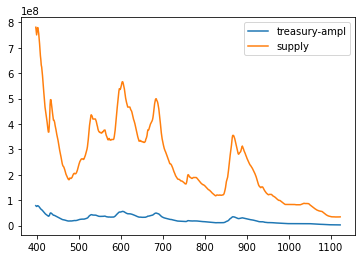

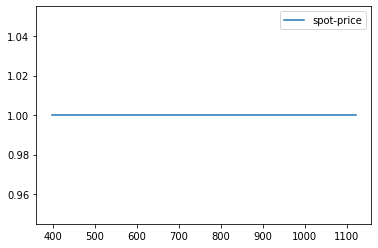

In [142]:
plt.plot(amplDf['epoch'], treasuryAmplBalances, label="treasury-ampl")
# plt.plot(amplDf['epoch'], minterAmplBalances,label="minter-ampl")
plt.plot(amplDf['epoch'], supplies,label="supply")
plt.legend()
plt.show()

plt.plot(amplDf['epoch'], prices, label="spot-price")
plt.legend()
plt.show()